# Import the libraries

In [2]:
# Import libraries
import numpy as np               # Arrary
import pandas as pd              # DataFrame
import matplotlib.pyplot as plt  # Plotting
import math                      # Pi value


In [3]:
# libraries
import sys
import pandas as pd
import numpy as np
from pandas               import DataFrame
from pandas               import Series
from pandas               import read_csv
from pandas               import get_dummies
from numpy                import array
from numpy                import random
from numpy                import where
from numpy                import nan
from scipy.stats.mstats   import winsorize
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics      import auc
from sklearn.metrics      import roc_auc_score
from matplotlib           import pyplot
from datetime             import datetime 

from pandas                 import DataFrame
from pandas                 import read_csv
from numpy                  import array
from numpy                  import random
from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import accuracy_score
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score
from matplotlib             import pyplot
from sklearn.utils          import resample
from sklearn.metrics        import confusion_matrix

In [4]:
#local libraries
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

# Import the raw data

In [5]:
# Import donoation data

# Each record describes characteristics of a campaign20130411
campaign2013 = pd.read_csv("C:/Users/jmotyl/Documents/Predictive analysis/group project/campaign20130411.csv", sep=';')

# Each record describes static characteristics of an campaign20140115
campaign2014 = pd.read_csv('C:/Users/jmotyl/Documents/Predictive analysis/group project/campaign20140115.csv', sep=';')

# Each record describes a credit card issued to an donors
donors = pd.read_csv('C:/Users/jmotyl/Documents/Predictive analysis/group project/donors.csv', sep=';')

# Each record describes demographic characteristics of a gifts
gifts = pd.read_csv('C:/Users/jmotyl/Documents/Predictive analysis/group project/gifts.csv', sep=';')


# Check the dataframes

### Check variables 

In [6]:
campaign2013.head()

,donorID,amount
0,100001,0.0
1,100002,0.0
2,100004,0.0
3,100008,0.0
4,100009,0.0


In [7]:
campaign2014.head()

,donorID,amount
0,100001,0.0
1,100002,0.0
2,100008,0.0
3,100009,0.0
4,100010,0.0


In [8]:
donors.head()

,donorID,gender,language,zipcode,region
0,100001,M,N,1861,Missing
1,100002,M,F,2260,13049A090
2,100003,M,F,1780,21004A24-
3,100004,M,N,1020,Missing
4,100005,F,F,1020,21004F522


In [9]:
gifts.head()

,campID,donorID,amount,date
0,0,100001,12.39,23/10/1998
1,1577,100001,12.39,18/08/1999
2,1634,100001,6.69,31/12/1999
3,1778,100001,24.79,19/10/2000
4,1808,100001,7.44,29/12/2000


### Check for missing values

In [10]:
campaign2013.isna().sum().sum()

0

In [11]:
campaign2014.isna().sum().sum()

0

In [12]:
donors.isna().sum()

donorID     0
gender      0
language    0
zipcode     1
region      0
dtype: int64

In [13]:
gifts.isna().sum().sum()

0

### Check the structure of the dataframes

In [14]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 5 columns):
donorID     44691 non-null int64
gender      44691 non-null object
language    44691 non-null object
zipcode     44690 non-null object
region      44691 non-null object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [15]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215042 entries, 0 to 215041
Data columns (total 4 columns):
campID     215042 non-null int64
donorID    215042 non-null int64
amount     215042 non-null float64
date       215042 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 6.6+ MB


# Data Transformation

#### Add variable "above35" in the campaign dataframes as target variable

In [16]:
campaign2013["above35"] = (campaign2013["amount"]>35).astype(int)
campaign2013.above35.sum()

518

In [17]:
campaign2014["above35"] = (campaign2014["amount"]>35).astype(int)
campaign2014.above35.sum()

152

#### Change the dates in Gifts to datetime format

In [18]:
gifts['date']=pd.to_datetime(gifts['date'])

gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215042 entries, 0 to 215041
Data columns (total 4 columns):
campID     215042 non-null int64
donorID    215042 non-null int64
amount     215042 non-null float64
date       215042 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 6.6 MB


#### Separate Gifts into two datasets (training and test) based on the date of the reactivation campaigns

In [19]:
#Gifts subset to be used for training data 
giftsTraining = gifts.loc[gifts['date']<"2013-04-11",:].reset_index()

giftsTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208196 entries, 0 to 208195
Data columns (total 5 columns):
index      208196 non-null int64
campID     208196 non-null int64
donorID    208196 non-null int64
amount     208196 non-null float64
date       208196 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 7.9 MB


In [20]:
#Gifts subset to be used for testing data 
giftsTest = gifts.loc[gifts['date']<"2014-01-15",:].reset_index()

giftsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212096 entries, 0 to 212095
Data columns (total 5 columns):
index      212096 non-null int64
campID     212096 non-null int64
donorID    212096 non-null int64
amount     212096 non-null float64
date       212096 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 8.1 MB


## Calculate and add various variables to be used for modeling 

## Gifts table 

In [21]:
#Gifts for training
giftsTrainingV2 = giftsTraining.groupby('donorID').agg({'amount':['sum','mean','count', 'max'],'date':['max', 'min']}).reset_index()

giftsTrainingV2.head() 

donorID  amount                               date           
              sum       mean count    max        max        min
0  100001  178.49  14.874167    12  30.00 2006-12-18 1998-10-23
1  100002   20.00  20.000000     1  20.00 2010-09-04 2010-09-04
2  100003   26.00   3.714286     7   5.00 2013-03-10 2011-02-08
3  100004  716.22  27.546923    26  49.58 2005-12-19 1995-05-18
4  100005   14.96   3.740000     4   5.00 2012-12-19 1997-11-14

In [22]:
#Gifts for training
giftsTestV2 = giftsTest.groupby('donorID').agg({'amount':['sum','mean','count', 'max'],'date':['max', 'min']}).reset_index()

giftsTestV2.head() 

donorID  amount                               date           
              sum       mean count    max        max        min
0  100001  178.49  14.874167    12  30.00 2006-12-18 1998-10-23
1  100002   20.00  20.000000     1  20.00 2010-09-04 2010-09-04
2  100003   42.00   3.818182    11   5.00 2013-12-19 2011-02-08
3  100004  716.22  27.546923    26  49.58 2005-12-19 1995-05-18
4  100005   24.96   4.992000     5  10.00 2013-10-24 1997-11-14

In [23]:
#the resultant dataframe has multi-level index

giftsTrainingV2.columns 

MultiIndex([('donorID',      ''),
            ( 'amount',   'sum'),
            ( 'amount',  'mean'),
            ( 'amount', 'count'),
            ( 'amount',   'max'),
            (   'date',   'max'),
            (   'date',   'min')],
           )

In [24]:
#Remove the multi-level indexing of both gifts tables

giftsTrainingV2.columns.droplevel()
giftsTrainingV2.columns = ["donorID", "total_donated", "average_donated", "times_donated", "max_donated", "last_donation", "first_donation"]

giftsTestV2.columns.droplevel()
giftsTestV2.columns = ["donorID", "total_donated", "average_donated", "times_donated", "max_donated", "last_donation", "first_donation"]

In [25]:
giftsTrainingV2.head()

,donorID,total_donated,average_donated,times_donated,max_donated,last_donation,first_donation
0,100001,178.49,14.874167,12,30.00,2006-12-18,1998-10-23
1,100002,20.00,20.000000,1,20.00,2010-09-04,2010-09-04
2,100003,26.00,3.714286,7,5.00,2013-03-10,2011-02-08
3,100004,716.22,27.546923,26,49.58,2005-12-19,1995-05-18
4,100005,14.96,3.740000,4,5.00,2012-12-19,1997-11-14


In [26]:
#We only want to target donors that didn't donate 'recently'
#We consider that people that did not donate in the last year didn't donate recently.
DonorRecently=giftsTrainingV2[giftsTrainingV2.last_donation>'2012-04-10']['donorID']

In [27]:
#We are putting aside the IDs of the donors that donated recently on the gifts file.
giftsTrainingV2 = giftsTrainingV2[giftsTrainingV2.donorID.isin(DonorRecently)==False]
giftsTestV2 = giftsTestV2[giftsTestV2.donorID.isin(DonorRecently)==False]

In [28]:
giftsTestV2.head()

,donorID,total_donated,average_donated,times_donated,max_donated,last_donation,first_donation
0,100001,178.49,14.874167,12,30.00,2006-12-18,1998-10-23
1,100002,20.00,20.000000,1,20.00,2010-09-04,2010-09-04
3,100004,716.22,27.546923,26,49.58,2005-12-19,1995-05-18
5,100006,5.00,5.000000,1,5.00,2011-02-09,2011-02-09
7,100008,124.37,41.456667,3,50.00,2006-07-27,1998-10-27


In [29]:
#Create the average number of days in between each donation

giftsTrainingV2['avg_days_gap'] = ((giftsTrainingV2['last_donation']-giftsTrainingV2['first_donation'])/giftsTrainingV2['times_donated']).astype('timedelta64[D]').astype(int)

giftsTestV2['avg_days_gap'] = ((giftsTestV2['last_donation']-giftsTestV2['first_donation'])/giftsTestV2['times_donated']).astype('timedelta64[D]').astype(int)

In [30]:
#Create the average number of days since last donation

giftsTrainingV2['days_since_first']=(datetime(2013,4,11)-giftsTrainingV2['first_donation']).astype('timedelta64[D]')
giftsTestV2['days_since_first']=(datetime(2014,1,15)-giftsTestV2['first_donation']).astype('timedelta64[D]')

giftsTrainingV2['days_since_last']=(datetime(2013,4,11)-giftsTrainingV2['last_donation']).astype('timedelta64[D]')
giftsTestV2['days_since_last']=(datetime(2014,1,15)-giftsTestV2['last_donation']).astype('timedelta64[D]')

In [31]:
giftsTrainingV2.head()

,donorID,total_donated,average_donated,times_donated,max_donated,last_donation,first_donation,avg_days_gap,days_since_first,days_since_last
0,100001,178.49,14.874167,12,30.00,2006-12-18,1998-10-23,248,5284.0,2306.0
1,100002,20.00,20.000000,1,20.00,2010-09-04,2010-09-04,0,950.0,950.0
3,100004,716.22,27.546923,26,49.58,2005-12-19,1995-05-18,148,6538.0,2670.0
5,100006,5.00,5.000000,1,5.00,2011-02-09,2011-02-09,0,792.0,792.0
7,100008,124.37,41.456667,3,50.00,2006-07-27,1998-10-27,943,5280.0,2450.0


In [32]:
giftsTestV2.head()

,donorID,total_donated,average_donated,times_donated,max_donated,last_donation,first_donation,avg_days_gap,days_since_first,days_since_last
0,100001,178.49,14.874167,12,30.00,2006-12-18,1998-10-23,248,5563.0,2585.0
1,100002,20.00,20.000000,1,20.00,2010-09-04,2010-09-04,0,1229.0,1229.0
3,100004,716.22,27.546923,26,49.58,2005-12-19,1995-05-18,148,6817.0,2949.0
5,100006,5.00,5.000000,1,5.00,2011-02-09,2011-02-09,0,1071.0,1071.0
7,100008,124.37,41.456667,3,50.00,2006-07-27,1998-10-27,943,5559.0,2729.0


In [33]:
#drop the columns with dates as they are not needed anymore

giftsTrainingV3 = giftsTrainingV2.drop(columns=["last_donation", "first_donation"])

In [34]:
giftsTrainingV3.head()

,donorID,total_donated,average_donated,times_donated,max_donated,avg_days_gap,days_since_first,days_since_last
0,100001,178.49,14.874167,12,30.00,248,5284.0,2306.0
1,100002,20.00,20.000000,1,20.00,0,950.0,950.0
3,100004,716.22,27.546923,26,49.58,148,6538.0,2670.0
5,100006,5.00,5.000000,1,5.00,0,792.0,792.0
7,100008,124.37,41.456667,3,50.00,943,5280.0,2450.0


In [35]:
#drop the columns with dates as they are not needed anymore

giftsTestV3 = giftsTestV2.drop(columns=["last_donation", "first_donation"])

In [36]:
giftsTestV3.head()

,donorID,total_donated,average_donated,times_donated,max_donated,avg_days_gap,days_since_first,days_since_last
0,100001,178.49,14.874167,12,30.00,248,5563.0,2585.0
1,100002,20.00,20.000000,1,20.00,0,1229.0,1229.0
3,100004,716.22,27.546923,26,49.58,148,6817.0,2949.0
5,100006,5.00,5.000000,1,5.00,0,1071.0,1071.0
7,100008,124.37,41.456667,3,50.00,943,5559.0,2729.0


## Donors Table

In [37]:
donors.head()

,donorID,gender,language,zipcode,region
0,100001,M,N,1861,Missing
1,100002,M,F,2260,13049A090
2,100003,M,F,1780,21004A24-
3,100004,M,N,1020,Missing
4,100005,F,F,1020,21004F522


In [38]:
#delete region because have too many missing values

donorsV2= donors.drop(['region'], axis=1) 

donorsV2.head()

,donorID,gender,language,zipcode
0,100001,M,N,1861
1,100002,M,F,2260
2,100003,M,F,1780
3,100004,M,N,1020
4,100005,F,F,1020


In [39]:
#Turn language into dummies (0 for N, 1 for F)

dictionary1= {"N":0, "F":1}

donorsV3 = donorsV2.replace({"language": dictionary1})

donorsV3.head()

,donorID,gender,language,zipcode
0,100001,M,0,1861
1,100002,M,1,2260
2,100003,M,1,1780
3,100004,M,0,1020
4,100005,F,1,1020


In [40]:
#drop the erroneous zipcodes and keep only those which are 4 digits long

donorsV4= donorsV3[donorsV3.zipcode.str.len()==4]

#Convert the zipcodes into integer data format

donorsV4['zipcode']=donorsV4['zipcode'].astype(int)

C:\Users\jmotyl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [41]:
#create a function to convert zipcode into Regions
def reg(z):
    region = ""
    if z >= 1000 and z<= 1299:
        region = 'Brussels Capital Region'
    elif z >= 1300 and z<= 1499:
        region = 'Walloon Brabant'
    elif z >= 1500 and z<= 1999:
        region = 'Flemish Brabant'
    elif z >= 2000 and z<= 2999:
        region = 'Antwerp'
    elif z >= 3000 and z<= 3499:
        region = 'Flemish Brabant'
    elif z >= 3500 and z<= 3999:
        region = 'Limburg'
    elif z >= 4000 and z<= 4999:
        region = 'Liège'
    elif z >= 5000 and z<= 5999:
        region = 'Namur'
    elif z >= 6000 and z<= 6599:
        region = 'Hainaut'
    elif z >= 6600 and z<= 6999:
        region = 'Luxembourg'
    elif z >= 7000 and z<= 7999:
        region = 'Hainaut'
    elif z >= 8000 and z<= 8999:
        region = 'West Flanders'
    elif z >= 9000 and z<= 9999:
        region = 'East Flanders'
    else :
        print('error')
    return(region)

In [42]:
#Apply the above created function to convert the zipcode into Regions 

donorsV5 = donorsV4
donorsV5["zipcode"] = donorsV5["zipcode"].apply(reg)

C:\Users\jmotyl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [43]:
donorsV5.head()

,donorID,gender,language,zipcode
0,100001,M,0,Flemish Brabant
1,100002,M,1,Antwerp
2,100003,M,1,Flemish Brabant
3,100004,M,0,Brussels Capital Region
4,100005,F,1,Brussels Capital Region


In [44]:
#Convert zipcode and gender into dummy variables

donorsV6 = donorsV5
donorsV6 = donorsV6.join(get_dummies(donorsV6["gender"], prefix="is",drop_first=False))
donorsV6 = donorsV6.join(get_dummies(donorsV6["zipcode"], prefix="from",drop_first=False))

donorsV6 = donorsV6.drop(columns="zipcode")
donorsV6 = donorsV6.drop(columns="gender")
donorsV6.head()

,donorID,language,is_C,is_F,is_M,is_S,is_U,from_Antwerp,from_Brussels Capital Region,from_East Flanders,from_Flemish Brabant,from_Hainaut,from_Limburg,from_Liège,from_Luxembourg,from_Namur,from_Walloon Brabant,from_West Flanders
0,100001,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,100002,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,100003,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,100004,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,100005,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [45]:
#Rename the gender column:
#C -> Couple  S -> Sotro (small business ?)  U -> Unknown

donorsV6.rename(columns={'is_C': 'is_Couple','is_F': 'is_Female','is_M':'is_Male','is_S':'is_Sotro','is_U':'is_Unknown'}, inplace=True)

In [46]:
donorsV6.columns

Index(['donorID', 'language', 'is_Couple', 'is_Female', 'is_Male', 'is_Sotro',
       'is_Unknown', 'from_Antwerp', 'from_Brussels Capital Region',
       'from_East Flanders', 'from_Flemish Brabant', 'from_Hainaut',
       'from_Limburg', 'from_Liège', 'from_Luxembourg', 'from_Namur',
       'from_Walloon Brabant', 'from_West Flanders'],
      dtype='object')

In [47]:
donorsV6.isna().sum()

donorID                         0
language                        0
is_Couple                       0
is_Female                       0
is_Male                         0
is_Sotro                        0
is_Unknown                      0
from_Antwerp                    0
from_Brussels Capital Region    0
from_East Flanders              0
from_Flemish Brabant            0
from_Hainaut                    0
from_Limburg                    0
from_Liège                      0
from_Luxembourg                 0
from_Namur                      0
from_Walloon Brabant            0
from_West Flanders              0
dtype: int64

# Merge the dataframes

### 1st merge:  to create a dataset of profile information for training

In [48]:
#Pandas merge to make master database of donors' demographic profile and gifts given before 11th Apr 2013 

left_table = giftsTrainingV3
right_table = donorsV6

MasterTraining = pd.merge(left_table,
                      right_table,
                      how="inner",
                      left_on="donorID",
                      right_on="donorID"
                     )
MasterTraining.isna().sum()

donorID                         0
total_donated                   0
average_donated                 0
times_donated                   0
max_donated                     0
avg_days_gap                    0
days_since_first                0
days_since_last                 0
language                        0
is_Couple                       0
is_Female                       0
is_Male                         0
is_Sotro                        0
is_Unknown                      0
from_Antwerp                    0
from_Brussels Capital Region    0
from_East Flanders              0
from_Flemish Brabant            0
from_Hainaut                    0
from_Limburg                    0
from_Liège                      0
from_Luxembourg                 0
from_Namur                      0
from_Walloon Brabant            0
from_West Flanders              0
dtype: int64

### 2nd merge: to create the 2013 Training set 

In [49]:
#Pandas 2nd merge to build the 2013 dataset as training set

left_table = MasterTraining
right_table = campaign2013

campaign2013V1 = pd.merge(left_table,
                      right_table,
                      how="inner",
                      left_on="donorID",
                      right_on="donorID"
                     )
campaign2013V1.isna().sum()

donorID                         0
total_donated                   0
average_donated                 0
times_donated                   0
max_donated                     0
avg_days_gap                    0
days_since_first                0
days_since_last                 0
language                        0
is_Couple                       0
is_Female                       0
is_Male                         0
is_Sotro                        0
is_Unknown                      0
from_Antwerp                    0
from_Brussels Capital Region    0
from_East Flanders              0
from_Flemish Brabant            0
from_Hainaut                    0
from_Limburg                    0
from_Liège                      0
from_Luxembourg                 0
from_Namur                      0
from_Walloon Brabant            0
from_West Flanders              0
amount                          0
above35                         0
dtype: int64

In [50]:
#check the size of the database after the merge. 
#5 observations lost as donors who donated in campaign but no history of gifts 

campaign2013V1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34545 entries, 0 to 34544
Data columns (total 27 columns):
donorID                         34545 non-null int64
total_donated                   34545 non-null float64
average_donated                 34545 non-null float64
times_donated                   34545 non-null int64
max_donated                     34545 non-null float64
avg_days_gap                    34545 non-null int32
days_since_first                34545 non-null float64
days_since_last                 34545 non-null float64
language                        34545 non-null int64
is_Couple                       34545 non-null uint8
is_Female                       34545 non-null uint8
is_Male                         34545 non-null uint8
is_Sotro                        34545 non-null uint8
is_Unknown                      34545 non-null uint8
from_Antwerp                    34545 non-null uint8
from_Brussels Capital Region    34545 non-null uint8
from_East Flanders              3

In [51]:
campaign2013V1.head()

,donorID,total_donated,average_donated,times_donated,max_donated,avg_days_gap,days_since_first,days_since_last,language,is_Couple,...,from_Flemish Brabant,from_Hainaut,from_Limburg,from_Liège,from_Luxembourg,from_Namur,from_Walloon Brabant,from_West Flanders,amount,above35
0,100001,178.49,14.874167,12,30.00,248,5284.0,2306.0,0,0,...,1,0,0,0,0,0,0,0,0.0,0
1,100002,20.00,20.000000,1,20.00,0,950.0,950.0,1,0,...,0,0,0,0,0,0,0,0,0.0,0
2,100004,716.22,27.546923,26,49.58,148,6538.0,2670.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
3,100008,124.37,41.456667,3,50.00,943,5280.0,2450.0,0,0,...,1,0,0,0,0,0,0,0,0.0,0
4,100009,326.78,17.198947,19,25.00,208,6157.0,2198.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0


### 3rd merge:  to create a dataset of profile information for testing

In [52]:
#Pandas merge to make master database of donors' demographic profile and gifts given before 15th Jan2014 
left_table = giftsTestV3
right_table = donorsV6

MasterTest = pd.merge(left_table,
                      right_table,
                      how="inner",
                      left_on="donorID",
                      right_on="donorID"
                     )
MasterTest.isna().sum()

donorID                         0
total_donated                   0
average_donated                 0
times_donated                   0
max_donated                     0
avg_days_gap                    0
days_since_first                0
days_since_last                 0
language                        0
is_Couple                       0
is_Female                       0
is_Male                         0
is_Sotro                        0
is_Unknown                      0
from_Antwerp                    0
from_Brussels Capital Region    0
from_East Flanders              0
from_Flemish Brabant            0
from_Hainaut                    0
from_Limburg                    0
from_Liège                      0
from_Luxembourg                 0
from_Namur                      0
from_Walloon Brabant            0
from_West Flanders              0
dtype: int64

### 4th merge:  to create the 2014 Test set 

In [53]:
#create the final test set by merging the master data set with the 2014 campaign data 

FinalTest2014 = pd.merge(MasterTest,
                         campaign2014,
                         how="inner",
                        left_on="donorID",
                        right_on="donorID") 

FinalTest2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25509 entries, 0 to 25508
Data columns (total 27 columns):
donorID                         25509 non-null int64
total_donated                   25509 non-null float64
average_donated                 25509 non-null float64
times_donated                   25509 non-null int64
max_donated                     25509 non-null float64
avg_days_gap                    25509 non-null int32
days_since_first                25509 non-null float64
days_since_last                 25509 non-null float64
language                        25509 non-null int64
is_Couple                       25509 non-null uint8
is_Female                       25509 non-null uint8
is_Male                         25509 non-null uint8
is_Sotro                        25509 non-null uint8
is_Unknown                      25509 non-null uint8
from_Antwerp                    25509 non-null uint8
from_Brussels Capital Region    25509 non-null uint8
from_East Flanders              2

In [54]:
#check the size of the database after the merge. 
#2 observations lost as donors who donated in campaign but no history of gifts 

FinalTest2014.isna().sum()

donorID                         0
total_donated                   0
average_donated                 0
times_donated                   0
max_donated                     0
avg_days_gap                    0
days_since_first                0
days_since_last                 0
language                        0
is_Couple                       0
is_Female                       0
is_Male                         0
is_Sotro                        0
is_Unknown                      0
from_Antwerp                    0
from_Brussels Capital Region    0
from_East Flanders              0
from_Flemish Brabant            0
from_Hainaut                    0
from_Limburg                    0
from_Liège                      0
from_Luxembourg                 0
from_Namur                      0
from_Walloon Brabant            0
from_West Flanders              0
amount                          0
above35                         0
dtype: int64

In [55]:
FinalTest2014.head()

,donorID,total_donated,average_donated,times_donated,max_donated,avg_days_gap,days_since_first,days_since_last,language,is_Couple,...,from_Flemish Brabant,from_Hainaut,from_Limburg,from_Liège,from_Luxembourg,from_Namur,from_Walloon Brabant,from_West Flanders,amount,above35
0,100001,178.49,14.874167,12,30.0,248,5563.0,2585.0,0,0,...,1,0,0,0,0,0,0,0,0.0,0
1,100002,20.00,20.000000,1,20.0,0,1229.0,1229.0,1,0,...,0,0,0,0,0,0,0,0,0.0,0
2,100008,124.37,41.456667,3,50.0,943,5559.0,2729.0,0,0,...,1,0,0,0,0,0,0,0,0.0,0
3,100009,326.78,17.198947,19,25.0,208,6436.0,2477.0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
4,100010,40.00,40.000000,1,40.0,0,1291.0,1291.0,1,1,...,0,0,0,0,0,0,0,0,0.0,0


### Windsorization and Log conversion

In [56]:
#applying logarithm/winsorize to all continuous variable to avoid biases

#Test Data

#campaign2013V1["days_since_first"] = winsorize(array(campaign2013V1["days_since_first"]), limits=[0.00,0.01])
campaign2013V1["days_since_first"]= np.log(campaign2013V1["days_since_first"])

#campaign2013V1["days_since_last"] = winsorize(array(campaign2013V1["days_since_last"]), limits=[0.00,0.01])
campaign2013V1["days_since_last"]= campaign2013V1["days_since_last"].apply(lambda row : np.log(row) if (row>0) else 0)

campaign2013V1["total_donated"] = winsorize(array(campaign2013V1["total_donated"]), limits=[0.00,0.01])
campaign2013V1["total_donated"]= np.log(campaign2013V1["total_donated"])

campaign2013V1["times_donated"] = winsorize(array(campaign2013V1["times_donated"]), limits=[0.00,0.01])
campaign2013V1["times_donated"]=round(campaign2013V1["times_donated"],4)

campaign2013V1["average_donated"] = winsorize(array(campaign2013V1["average_donated"]), limits=[0.00,0.01])
campaign2013V1["average_donated"]= np.log(campaign2013V1["average_donated"])

campaign2013V1["avg_days_gap"] = winsorize(array(campaign2013V1["avg_days_gap"]), limits=[0.00,0.01])
campaign2013V1["avg_days_gap"]= campaign2013V1["avg_days_gap"].apply(lambda row : np.log(row) if (row>0) else 0)

campaign2013V1["max_donated"] = winsorize(array(campaign2013V1["max_donated"]), limits=[0.00,0.01])
campaign2013V1["max_donated"]= campaign2013V1["max_donated"].apply(lambda row : np.log(row) if (row>0) else 0)


#Training Data

#FinalTest2014["days_since_first"] = winsorize(array(FinalTest2014["days_since_first"]), limits=[0.00,0.01])
FinalTest2014["days_since_first"]= np.log(FinalTest2014["days_since_first"])

#FinalTest2014["days_since_last"] = winsorize(array(FinalTest2014["days_since_last"]), limits=[0.00,0.01])
FinalTest2014["days_since_last"]= np.log(FinalTest2014["days_since_last"])

FinalTest2014["total_donated"] = winsorize(array(FinalTest2014["total_donated"]), limits=[0.00,0.01])
FinalTest2014["total_donated"]= np.log(FinalTest2014["total_donated"])

FinalTest2014["average_donated"] = winsorize(array(FinalTest2014["average_donated"]), limits=[0.00,0.01])
FinalTest2014["average_donated"]= np.log(FinalTest2014["average_donated"])

FinalTest2014["avg_days_gap"] = winsorize(array(FinalTest2014["avg_days_gap"]), limits=[0.00,0.01])
FinalTest2014["avg_days_gap"]= FinalTest2014["avg_days_gap"].apply(lambda row : np.log(row) if (row>0) else 0)

FinalTest2014["times_donated"] = winsorize(array(FinalTest2014["times_donated"]), limits=[0.00,0.01])
FinalTest2014["times_donated"] = np.log(FinalTest2014["times_donated"])

FinalTest2014["max_donated"] = winsorize(array(FinalTest2014["max_donated"]), limits=[0.00,0.01])
FinalTest2014["max_donated"] = np.log(FinalTest2014["max_donated"])

campaign2013V1["total_donated"].describe()

count    34545.000000
mean         3.872234
std          1.195065
min          1.609438
25%          3.210440
50%          3.688879
75%          4.667018
max          6.879479
Name: total_donated, dtype: float64

In [57]:
campaign2013V1["times_donated"].describe()

count    34545.000000
mean         3.880417
std          5.178051
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         31.000000
Name: times_donated, dtype: float64

In [58]:
indextoNull= FinalTest2014.index[FinalTest2014.average_donated.isnull()==True]
FinalTest2014.iloc[indextoNull,2]= FinalTest2014.average_donated.mean()

In [59]:
FinalTest2014.var()

donorID                         1.464294e+08
total_donated                   1.494269e+00
average_donated                 5.046678e-01
times_donated                   8.873324e-01
max_donated                     5.689763e-01
avg_days_gap                    7.789089e+00
days_since_first                3.207756e-01
days_since_last                 3.096282e-01
language                        7.476277e-02
is_Couple                       1.453449e-01
is_Female                       2.324886e-01
is_Male                         2.354070e-01
is_Sotro                        4.500854e-02
is_Unknown                      2.861185e-02
from_Antwerp                    1.774438e-01
from_Brussels Capital Region    2.835354e-02
from_East Flanders              1.669969e-01
from_Flemish Brabant            1.288091e-01
from_Hainaut                    1.676266e-02
from_Limburg                    1.022455e-01
from_Liège                      1.725467e-02
from_Luxembourg                 5.768438e-03
from_Namur

In [60]:
print(campaign2013V1[campaign2013V1.above35==1]["above35"].sum())
print(campaign2013V1.shape)
test = 34909-517
test

490
(34545, 27)


34392

In [61]:
campaign2013V1.above35.value_counts()

0    34055
1      490
Name: above35, dtype: int64

In [62]:
# Separate majority and minority classes
campaign2013V1_majority = campaign2013V1[campaign2013V1.above35==0]
campaign2013V1_minority = campaign2013V1[campaign2013V1.above35==1]

In [63]:
# Upsample minority class
campaign2013V1_minority_upsampled = resample(campaign2013V1_minority, 
                                             replace=True,     # sample with replacement
                                             n_samples=34392,    # to match majority class
                                             random_state=123) # reproducible results

In [64]:
# Combine majority class with upsampled minority class
campaign2013V1_upsampled = pd.concat([campaign2013V1_majority, campaign2013V1_minority_upsampled])
 
# Display new class counts
campaign2013V1_upsampled.above35.value_counts()
#campaign2013V1_upsampled is the new set to partition

1    34392
0    34055
Name: above35, dtype: int64

In [65]:
partitions = partition(dataFrame = campaign2013V1_upsampled, splitStrategy = [0.8,0.2])
for (index,dataFrame) in enumerate(partitions):
    print(f"Partition {index} shape : {dataFrame.shape} ({len(dataFrame)/len(campaign2013V1_upsampled)})")

Partition 0 shape : (54758, 27) (1.5851208568533797)
Partition 1 shape : (13689, 27) (0.39626574033868867)


In [66]:
trainingSet   = partitions[0]
validationSet = partitions[1]
testSet       = FinalTest2014

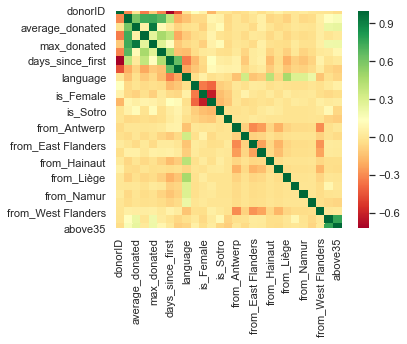

In [67]:
#Displaying graphically the correlation between all the feature.
import seaborn as sns; sns.set()
sns.heatmap(trainingSet.corr(), square=True, cmap='RdYlGn')

# Modelling

# BELOW IS THE TESTS FOR THE RANDOM FOREST

In [68]:
#Separating the features from the target for random forest fitting
target = "above35"
selected = trainingSet.drop(columns=["donorID", "amount", "above35"])
selected = selected.columns.values
print(selected)

['total_donated' 'average_donated' 'times_donated' 'max_donated'
 'avg_days_gap' 'days_since_first' 'days_since_last' 'language'
 'is_Couple' 'is_Female' 'is_Male' 'is_Sotro' 'is_Unknown' 'from_Antwerp'
 'from_Brussels Capital Region' 'from_East Flanders'
 'from_Flemish Brabant' 'from_Hainaut' 'from_Limburg' 'from_Liège'
 'from_Luxembourg' 'from_Namur' 'from_Walloon Brabant'
 'from_West Flanders']


In [69]:
def fisherscore(X, y):
    """
    This function calculate the Fisher score of all variables of the basetable.
    
    Input:
        
        X: [Pandas Dataframe] the independent variables basetable for modeling.
        y: [Pandas Series] the target variable.
        
    Output:
        
        Pandas Dataframe contains the Fisher score for each independent varibales.
    
    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the list of independent variables
    vars_list = X.columns
    
    # Get the unique values of dependent/target variable
    # Should be 2 classes [0, 1]
    target_unique = y.unique()
  
    iv_fisherscore = []
    
    for v in vars_list:
        fs = np.abs(np.mean(X.loc[y == target_unique[0], v]) - \
                    np.mean(X.loc[y == target_unique[1], v])) / \
             np.sqrt(np.var(X.loc[y == target_unique[0], v]) + \
                     np.var(X.loc[y == target_unique[1], v]))
        iv_fisherscore.append(fs)
        
    return pd.DataFrame(iv_fisherscore, index=vars_list, columns=['fisher_score'])

In [70]:
# Apply Fisher Score
fs = fisherscore(trainingSet[selected],trainingSet[target])
fs = fs.sort_values(by='fisher_score', ascending=False)

In [71]:
# Extract top 15 variables
fs[:15]

,fisher_score
average_donated,0.357040
max_donated,0.314969
total_donated,0.245852
is_Unknown,0.127677
avg_days_gap,0.123835
days_since_last,0.122245
language,0.091121
from_Walloon Brabant,0.090707
is_Sotro,0.086398
is_Couple,0.080646


In [72]:
fs.index[:15]

Index(['average_donated', 'max_donated', 'total_donated', 'is_Unknown',
       'avg_days_gap', 'days_since_last', 'language', 'from_Walloon Brabant',
       'is_Sotro', 'is_Couple', 'from_Brussels Capital Region', 'from_Limburg',
       'from_Hainaut', 'is_Male', 'is_Female'],
      dtype='object')

In [73]:
#Fitting the random forest with custom parameters (we experienced different sets of parameters, varying from 10 to 1000 estimators, 1 to 50 depth)
randomForest = RandomForestClassifier(n_estimators = 300, class_weight='balanced',max_depth=4)


In [74]:
randomForest.fit(trainingSet[selected], trainingSet[target])

trainingSet["proba donated"] = DataFrame(randomForest.predict_proba(trainingSet[selected]))[1]
validationSet["proba donated"]     = DataFrame(randomForest.predict_proba(validationSet[selected]))[1]
testSet["proba donated"]     = DataFrame(randomForest.predict_proba(testSet[selected]))[1]

aucTraining       = roc_auc_score(array(trainingSet[target]),array(trainingSet["proba donated"]))
aucValidation     = roc_auc_score(array(validationSet[target]),array(validationSet["proba donated"]))
aucTest           = roc_auc_score(array(testSet[target]),array(testSet["proba donated"]))
        
trainingSet.drop("proba donated", axis = 1)
validationSet.drop("proba donated", axis = 1)
testSet.drop("proba donated",axis=1)

print(selected,aucTraining,aucValidation,aucTest)

['total_donated' 'average_donated' 'times_donated' 'max_donated'
 'avg_days_gap' 'days_since_first' 'days_since_last' 'language'
 'is_Couple' 'is_Female' 'is_Male' 'is_Sotro' 'is_Unknown' 'from_Antwerp'
 'from_Brussels Capital Region' 'from_East Flanders'
 'from_Flemish Brabant' 'from_Hainaut' 'from_Limburg' 'from_Liège'
 'from_Luxembourg' 'from_Namur' 'from_Walloon Brabant'
 'from_West Flanders'] 0.7351515680636397 0.7276453899915936 0.6907973188183623


In [75]:
randomForest.feature_importances_

array([1.32849659e-01, 3.00676087e-01, 2.90974637e-02, 2.31860496e-01,
       7.97398158e-02, 4.29948013e-02, 8.98926209e-02, 1.08676653e-02,
       8.36975686e-03, 4.61028977e-03, 2.35581018e-03, 1.29838835e-02,
       2.46349640e-02, 1.24306397e-03, 3.54439021e-03, 4.83070338e-03,
       3.53113174e-03, 1.46737759e-03, 2.05593832e-03, 3.43951086e-04,
       5.26483289e-04, 1.12233224e-04, 1.04370838e-02, 9.74329735e-04])

In [76]:
#what is it missing in the validationSet ?
confusion_matrix(validationSet[target], randomForest.predict(validationSet[selected]))
#It is missing some true but mostly predicting false positive

array([[3013, 3838],
       [ 900, 5938]], dtype=int64)

In [77]:
confusion_matrix(trainingSet[target], randomForest.predict(trainingSet[selected]))

array([[11897, 15307],
       [ 3463, 24091]], dtype=int64)

In [78]:
confusion_matrix(testSet[target], randomForest.predict(testSet[selected]))

array([[10815, 14543],
       [   23,   128]], dtype=int64)

#### END OF THE TEST FOR RANDOM FOREST

In [79]:
trainingSet = trainingSet.drop(columns=["proba donated"])
validationSet = validationSet.drop(columns=["proba donated"])

# Testing Linear Regression

In [80]:
def stepwiseRegresion (trainingSet: DataFrame, validationSet: DataFrame, selectedFeatures: [str], target: [str], Model = DecisionTreeClassifier()) -> DataFrame:

    def computeAUC (forFeatures: [str]) -> ([str],float,float):
    
        Model.fit(trainingSet[forFeatures], trainingSet[target])

        trainingSet["proba donated stepwise"] = DataFrame(Model.predict_proba(trainingSet[forFeatures]))[1]
        validationSet["proba donated stepwise"]     = DataFrame(Model.predict_proba(validationSet[forFeatures]))[1]

        aucTraining = roc_auc_score(array(trainingSet[target]),array(trainingSet["proba donated stepwise"]))
        aucTest     = roc_auc_score(array(validationSet[target]),array(validationSet["proba donated stepwise"]))
        
        trainingSet.drop("proba donated stepwise", axis = 1)
        validationSet.drop("proba donated stepwise", axis = 1)

        return (forFeatures,aucTraining,aucTest)

    featuresOrder = []
    forwardSelection = []
    df={}
    
    for step in range(len(selectedFeatures)):
        out=step
        print(f"step {step+1}" + " of " + str(Model)[:12])
        aucs = []
        for feature in selectedFeatures:
            if feature not in featuresOrder:
                modelFeatures = featuresOrder.copy()
                modelFeatures.append(feature)
                aucs.append(computeAUC(forFeatures = modelFeatures))
            
        steps = DataFrame(aucs)
        steps.columns = ["Feature","AUC training", "AUC test"]
        steps = steps.sort_values(by=["AUC test"], ascending = False)

        featuresOrder = steps["Feature"].iloc[0]
        forwardSelection.append((step+1, steps["Feature"].iloc[0],steps["AUC training"].iloc[0],steps["AUC test"].iloc[0]))
        #print(forwardSelection[step][2])
        #if (forwardSelection[step][3] < (forwardSelection[step-1][3] -0.01)):
         #   print("AUC score decreasing ! Stopping stepwise regression.")
          #  out=step-1
           # break
        
        
    #df = DataFrame(forwardSelection)
    #df.columns = ("Step","Features","AUC Train","AUC Test")
    
    #df["model{0}".format(str(models[testing])[:12])]=forwardSelection[step][1:4]
    #print(df)
   
    return forwardSelection

In [81]:
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 1000)
linear = stepwiseRegresion(trainingSet      = trainingSet, 
                                     validationSet          = validationSet, 
                                     selectedFeatures = selected,
                                     target           = target,
                                        Model = logistic)
    

step 1 of LogisticRegr
step 2 of LogisticRegr
step 3 of LogisticRegr
step 4 of LogisticRegr
step 5 of LogisticRegr
step 6 of LogisticRegr
step 7 of LogisticRegr
step 8 of LogisticRegr
step 9 of LogisticRegr
step 10 of LogisticRegr
step 11 of LogisticRegr
step 12 of LogisticRegr
step 13 of LogisticRegr
step 14 of LogisticRegr
step 15 of LogisticRegr
step 16 of LogisticRegr
step 17 of LogisticRegr
step 18 of LogisticRegr
step 19 of LogisticRegr
step 20 of LogisticRegr
step 21 of LogisticRegr
step 22 of LogisticRegr
step 23 of LogisticRegr
step 24 of LogisticRegr


In [82]:
linear2 = DataFrame(linear)
print(linear2)
feat=linear2.iloc[19,1]

     0                                                  1         2         3
0    1                                  [average_donated]  0.633302  0.631112
1    2                    [average_donated, avg_days_gap]  0.644746  0.642038
2    3         [average_donated, avg_days_gap, is_Couple]  0.650030  0.649967
3    4  [average_donated, avg_days_gap, is_Couple, is_...  0.655601  0.655544
4    5  [average_donated, avg_days_gap, is_Couple, is_...  0.661734  0.660679
5    6  [average_donated, avg_days_gap, is_Couple, is_...  0.665872  0.663027
6    7  [average_donated, avg_days_gap, is_Couple, is_...  0.668987  0.665455
7    8  [average_donated, avg_days_gap, is_Couple, is_...  0.670405  0.667672
8    9  [average_donated, avg_days_gap, is_Couple, is_...  0.674143  0.670065
9   10  [average_donated, avg_days_gap, is_Couple, is_...  0.677375  0.672700
10  11  [average_donated, avg_days_gap, is_Couple, is_...  0.678824  0.674254
11  12  [average_donated, avg_days_gap, is_Couple, is_...  0.679

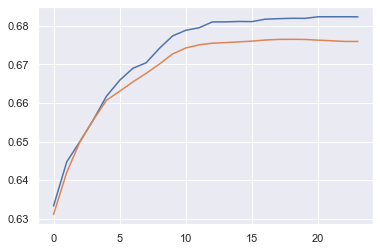

In [83]:
plt.plot(linear2.iloc[:,2])
plt.plot(linear2.iloc[:,3])
plt.show()

In [84]:
logistic.fit(trainingSet[feat], trainingSet[target])

trainingSet["proba donated stepwise"] = DataFrame(logistic.predict_proba(trainingSet[feat]))[1]
validationSet["proba donated stepwise"]     = DataFrame(logistic.predict_proba(validationSet[feat]))[1]
testSet["proba donated stepwise"]     = DataFrame(logistic.predict_proba(testSet[feat]))[1]

aucTraining = roc_auc_score(array(trainingSet[target]),array(trainingSet["proba donated stepwise"]))
aucValidation     = roc_auc_score(array(validationSet[target]),array(validationSet["proba donated stepwise"]))
aucTest     = roc_auc_score(array(testSet[target]),array(testSet["proba donated stepwise"]))
        
#trainingSet.drop("proba donated stepwise", axis = 1)
#validationSet.drop("proba donated stepwise", axis = 1)

In [85]:
# Let's see the proportions of true positive predicted by the logistic regression
print(confusion_matrix(trainingSet[target], logistic.predict(trainingSet[feat])))
print(confusion_matrix(validationSet[target], logistic.predict(validationSet[feat])))
print(confusion_matrix(testSet[target], logistic.predict(testSet[feat])))

[[14534 12670]
 [ 7570 19984]]
[[3663 3188]
 [1901 4937]]
[[12277 13081]
 [   35   116]]


In [86]:
rocTraining = roc(dataSet = trainingSet, actuals = target, probability = "proba donated stepwise")
rocValidation     = roc(dataSet = validationSet, actuals = target, probability = "proba donated stepwise")
rocTest     = roc(dataSet = testSet, actuals = target, probability = "proba donated stepwise")

Text(0.5, 1.0, 'Receiver Operating Characteristic')

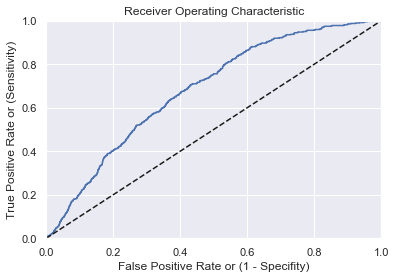

In [87]:
pyplot.plot(rocTraining["False positive rate"], rocTraining["True positive rate"])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel("False Positive Rate or (1 - Specifity)")
pyplot.ylabel("True Positive Rate or (Sensitivity)")
pyplot.title("Receiver Operating Characteristic")

Text(0.5, 1.0, 'Receiver Operating Characteristic')

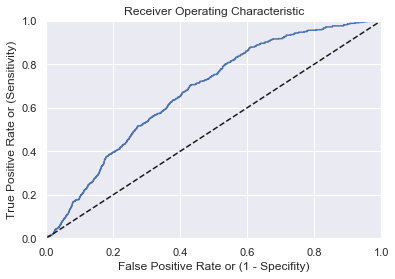

In [88]:
pyplot.plot(rocValidation["False positive rate"], rocValidation["True positive rate"])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel("False Positive Rate or (1 - Specifity)")
pyplot.ylabel("True Positive Rate or (Sensitivity)")
pyplot.title("Receiver Operating Characteristic")

Text(0.5, 1.0, 'Receiver Operating Characteristic')

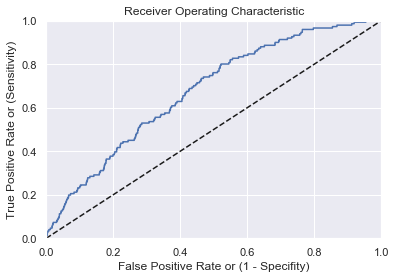

In [89]:
pyplot.plot(rocTest["False positive rate"], rocTest["True positive rate"])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel("False Positive Rate or (1 - Specifity)")
pyplot.ylabel("True Positive Rate or (Sensitivity)")
pyplot.title("Receiver Operating Characteristic")

In [90]:
lifts = lift(dataSet = validationSet, actuals = target, probability = "proba donated stepwise")

C:\Users\jmotyl\Documents\Predictive analysis\group project\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Users\jmotyl\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jmotyl\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [91]:
lifts.head()

,Quantile,Lift,Base
19,1.00,1.192373,1.0
18,0.95,1.304446,1.0
17,0.90,1.314783,1.0
16,0.85,1.302917,1.0
15,0.80,1.334212,1.0


Text(0.5, 1.0, 'Lift')

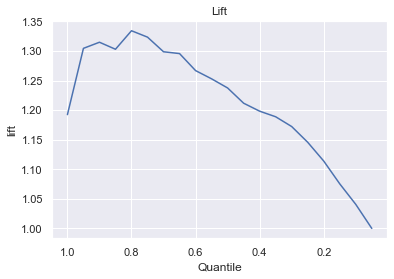

In [92]:
pyplot.plot(lifts["Quantile"], lifts["Lift"])
pyplot.gca().invert_xaxis()
pyplot.xlabel("Quantile")
pyplot.ylabel("lift")
pyplot.title("Lift")

In [93]:
#feature selection
from scipy.stats import pearsonr
target = "above35"
featselected = []
featureSet= trainingSet.columns
drop = ["donorID", "amount", "above35", "proba donated stepwise"]
for col in featureSet:
    if col not in drop:
        cor, pval = pearsonr(campaign2013V1[col], campaign2013V1[target])
        print(f"feature: {col}, cor: {cor}, pval:{pval}")
        if (cor > 0.01) | (cor < -0.01): #We only want to select features that are correlated to at least 1% to our target
            featselected.append(col)
print(featselected)

feature: total_donated, cor: 0.04024707128569949, pval:7.25362383072975e-14
feature: average_donated, cor: 0.05086846261526995, pval:3.0694353812558243e-21
feature: times_donated, cor: 0.006552414900166243, pval:0.22329256153718718
feature: max_donated, cor: 0.04609159881667218, pval:1.0262500111260855e-17
feature: avg_days_gap, cor: 0.021049761277522935, pval:9.128479623969136e-05
feature: days_since_first, cor: 0.003487750934773777, pval:0.5168414700203735
feature: days_since_last, cor: -0.020042408690439998, pval:0.0001950222767853204
feature: language, cor: -0.013930490077234276, pval:0.009620128374073762
feature: is_Couple, cor: 0.013603044293669014, pval:0.011460784719974994
feature: is_Female, cor: -0.007204105833847856, pval:0.18058871444457644
feature: is_Male, cor: 0.008268287545133824, pval:0.12435744076307846
feature: is_Sotro, cor: -0.012864319274827564, pval:0.01680202720021728
feature: is_Unknown, cor: -0.01638143748764678, pval:0.002328391019382245
feature: from_Antwerp

#### Checking if some features are higly correlated

In [94]:
trainingSet[featselected].corr()

,total_donated,average_donated,max_donated,avg_days_gap,days_since_last,language,is_Couple,is_Sotro,is_Unknown,from_Walloon Brabant
total_donated,1.000000,0.597672,0.743726,0.683444,-0.199925,-0.129515,-0.051447,0.059294,-0.054142,-0.036912
average_donated,0.597672,1.000000,0.939486,0.112006,-0.072113,-0.027905,-0.010632,0.114785,-0.041831,-0.013566
max_donated,0.743726,0.939486,1.000000,0.277866,-0.104870,-0.053901,-0.021958,0.115307,-0.047425,-0.019712
avg_days_gap,0.683444,0.112006,0.277866,1.000000,-0.137350,-0.152548,-0.036974,-0.023544,-0.032683,-0.036885
days_since_last,-0.199925,-0.072113,-0.104870,-0.137350,1.000000,-0.220825,-0.122200,0.075624,0.063974,-0.046079
language,-0.129515,-0.027905,-0.053901,-0.152548,-0.220825,1.000000,-0.034858,0.001653,-0.022227,0.220895
is_Couple,-0.051447,-0.010632,-0.021958,-0.036974,-0.122200,-0.034858,1.000000,-0.094510,-0.062875,-0.006790
is_Sotro,0.059294,0.114785,0.115307,-0.023544,0.075624,0.001653,-0.094510,1.000000,-0.026965,-0.003933
is_Unknown,-0.054142,-0.041831,-0.047425,-0.032683,0.063974,-0.022227,-0.062875,-0.026965,1.000000,-0.006361
from_Walloon Brabant,-0.036912,-0.013566,-0.019712,-0.036885,-0.046079,0.220895,-0.006790,-0.003933,-0.006361,1.000000


In [95]:
#dropping max_donated as it has a lower Fisher score than average_donated
featselected.remove("max_donated")

In [96]:
print(featselected)

['total_donated', 'average_donated', 'avg_days_gap', 'days_since_last', 'language', 'is_Couple', 'is_Sotro', 'is_Unknown', 'from_Walloon Brabant']


### Let's make sure our feature selection is relevant by comparing it with the Fisher score method

In [97]:
# Decision Tree (DT)
from sklearn.model_selection import cross_val_score

dt_churn = DecisionTreeClassifier(max_depth=10)
dt_churn.fit(trainingSet[featselected],trainingSet[target])

# Evaluate using cross-validation
score = cross_val_score(dt_churn, campaign2013V1_upsampled[featselected],campaign2013V1_upsampled[target], cv=5, scoring='roc_auc')  # k=5
score.mean()

0.7121698417956465

In [98]:
# Decision Tree (DT)
dt_churn = DecisionTreeClassifier(max_depth=10)
dt_churn.fit(trainingSet[fs.index[:15]],trainingSet[target])

# Evaluate using cross-validation
score = cross_val_score(dt_churn, campaign2013V1_upsampled[fs.index[:15]],campaign2013V1_upsampled[target], cv=5, scoring='roc_auc')  # k=5
score.mean()

0.7027791466505867

In [99]:
# Logistic Regression
lr_churn = LogisticRegression(solver = "lbfgs", max_iter = 1000, class_weight='balanced')
lr_churn.fit(trainingSet[featselected],trainingSet[target])

# Evaluate using cross-validation
score = cross_val_score(lr_churn, campaign2013V1_upsampled[featselected],campaign2013V1_upsampled[target], cv=5, scoring='roc_auc')  # k=5
score.mean()

0.5993509820309628

In [100]:
# Logistic Regression
lr_churn = LogisticRegression(solver = "lbfgs", max_iter = 1000, class_weight='balanced')
lr_churn.fit(trainingSet[fs.index[:15]],trainingSet[target])

# Evaluate using cross-validation
score = cross_val_score(lr_churn, campaign2013V1_upsampled[fs.index[:15]],campaign2013V1_upsampled[target], cv=5, scoring='roc_auc')  # k=5
score.mean()

0.6037508794438191

In [101]:
#random forest
rf_churn = RandomForestClassifier(n_estimators = 300, class_weight='balanced',max_depth=4,random_state=123)
rf_churn.fit(trainingSet[featselected],trainingSet[target])

# Evaluate using cross-validation
score = cross_val_score(rf_churn, campaign2013V1_upsampled[featselected],campaign2013V1_upsampled[target], cv=5, scoring='roc_auc')  # k=5
score.mean()

0.623694511966671

In [102]:
#random forest
rf_churn = RandomForestClassifier(n_estimators = 300, class_weight='balanced',max_depth=4,random_state=123)
rf_churn.fit(trainingSet[fs.index[:15]],trainingSet[target])

# Evaluate using cross-validation
score = cross_val_score(rf_churn, campaign2013V1_upsampled[fs.index[:15]],campaign2013V1_upsampled[target], cv=5, scoring='roc_auc')  # k=5
score.mean()

0.6440836781027766

In [103]:
# Gradient Boost Regression
lr_churn = GradientBoostingClassifier(max_depth=4, n_estimators= 300, validation_fraction=0.2)
lr_churn.fit(trainingSet[featselected],trainingSet[target])

# Evaluate using cross-validation
score = cross_val_score(lr_churn, campaign2013V1_upsampled[featselected],campaign2013V1_upsampled[target], cv=5, scoring='roc_auc')  # k=5
score.mean()

0.8399503040389229

In [104]:
# Gradient Boost Regression
lr_churn = GradientBoostingClassifier(max_depth=4, n_estimators= 300, validation_fraction=0.2)
lr_churn.fit(trainingSet[fs.index[:15]],trainingSet[target])

# Evaluate using cross-validation
score = cross_val_score(lr_churn, campaign2013V1_upsampled[fs.index[:15]],campaign2013V1_upsampled[target], cv=5, scoring='roc_auc')  # k=5
score.mean()

0.8506736761957363

In [105]:
#2. Instanciate the models

tree         = DecisionTreeClassifier(max_depth=4)
#logistic     = LogisticRegression(solver = "lbfgs", max_iter = 1000)
#LogisticRegression has been trained before with its own feature selection
randomForest = RandomForestClassifier(n_estimators = 300, class_weight='balanced',max_depth=4)
boostedTree  = GradientBoostingClassifier(max_depth=4,learning_rate=0.1)
neuralNet    = MLPClassifier(max_iter = 1000)
neighbors    = KNeighborsClassifier(n_neighbors=4)

models = {"tree"         :tree,
          "randomForest" :randomForest, #has been trained above with its own feature selection process, is here for the sake of comparison
          "boostedTree"  :boostedTree,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }

### The score are fairly close, our feature selection by correlation is valid.

In [106]:
#3. Train the models on the training set

for model in models:
    models[model].fit(trainingSet[featselected],trainingSet[target])
    print(f"{model} has been trained successfully")

tree has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully


In [107]:
#4. Compute Accuracy and AUC for each model

performances = {}

for model in models:
    predictions   = models[model].predict(validationSet[featselected])
    probabilities = DataFrame(models[model].predict_proba(validationSet[featselected]))[1]
    accuracy      = accuracy_score(validationSet[target],predictions)
    auc           = roc_auc_score(array(validationSet[target]),array(probabilities))
    
    performances[model] = {"AUCValidation":auc}
    
DataFrame(performances)

,tree,randomForest,boostedTree,neuralNet,neighbors
AUCValidation,0.698853,0.724192,0.868383,0.760786,0.980066


In [126]:
#For each algorithm plot the following on validation set:
    #  - Lift curve
    #  - Cumulative response
    #  - Cumulative gains

lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(validationSet[target]).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = DataFrame(models[model].predict_proba(validationSet[featselected]))[1]
    lifts[model] = lift(dataSet = data, actuals = "above35", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "above35", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "above35", probability = "proba "+str(model))

C:\Users\jmotyl\Documents\Predictive analysis\group project\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Users\jmotyl\Documents\Predictive analysis\group project\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Users\jmotyl\Documents\Predictive analysis\group project\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

### Lift, cumulative gains and response curves for the Boosted Tree

### Lift, cumulative gains and cumulative responses for all models

In [109]:
for model in models:
    print(model, responses[model])

tree    Quantile  Cumulative response  Average response
9      1.00             0.712142          0.499525
8      0.85             0.697501          0.499525
7      0.75             0.691587          0.499525
6      0.70             0.665009          0.499525
5      0.60             0.655730          0.499525
4      0.55             0.578436          0.499525
3      0.25             0.571983          0.499525
2      0.20             0.532681          0.499525
1      0.10             0.515846          0.499525
0      0.05             0.499525          0.499525
randomForest     Quantile  Cumulative response  Average response
19      1.00             0.791367          0.499525
18      0.95             0.756718          0.499525
17      0.90             0.754854          0.499525
16      0.85             0.741736          0.499525
15      0.80             0.726954          0.499525
14      0.75             0.712378          0.499525
13      0.70             0.698706          0.499525
12   

In [110]:
#CHOSING WHICH MODEL TO USE: Basically, you pick the percentile you want and you check the difference in results. Highest
#results is the model you chose to pick.
for model in models:
    print(model, lifts[model])

tree    Quantile      Lift  Base
9      1.00  1.425638   1.0
8      0.85  1.396327   1.0
7      0.75  1.384488   1.0
6      0.70  1.331283   1.0
5      0.60  1.312706   1.0
4      0.55  1.157972   1.0
3      0.25  1.145053   1.0
2      0.20  1.066374   1.0
1      0.10  1.032673   1.0
0      0.05  1.000000   1.0
randomForest     Quantile      Lift  Base
19      1.00  1.584238   1.0
18      0.95  1.514874   1.0
17      0.90  1.511144   1.0
16      0.85  1.484883   1.0
15      0.80  1.455291   1.0
14      0.75  1.426110   1.0
13      0.70  1.398741   1.0
12      0.65  1.355997   1.0
11      0.60  1.318476   1.0
10      0.55  1.304616   1.0
9       0.50  1.285588   1.0
8       0.45  1.262339   1.0
7       0.40  1.238844   1.0
6       0.35  1.220595   1.0
5       0.30  1.184492   1.0
4       0.25  1.155238   1.0
3       0.20  1.140626   1.0
2       0.15  1.101305   1.0
1       0.10  1.052110   1.0
0       0.05  1.000000   1.0
boostedTree     Quantile      Lift  Base
19      1.00  1.918127  

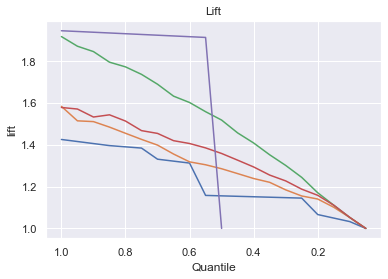

In [111]:
for model in models:
    pyplot.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("lift")
    pyplot.title("Lift")

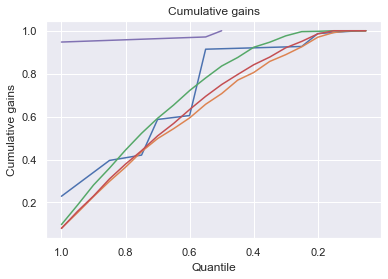

In [112]:
for model in models:
    pyplot.plot(gains[model]["Quantile"], gains[model]["Cumulative gains"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("Cumulative gains")
    pyplot.title("Cumulative gains")

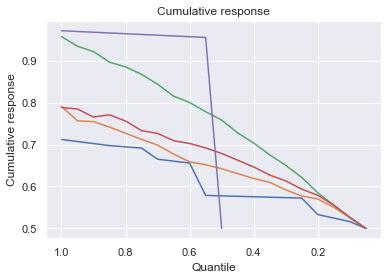

In [113]:
for model in models:
    pyplot.plot(responses[model]["Quantile"], responses[model]["Cumulative response"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("Cumulative response")
    pyplot.title("Cumulative response")

In [114]:
#4. Compute Accuracy and AUC for each model on test Set 

performances = {}

for model in models:
    predictions   = models[model].predict(testSet[featselected])
    probabilities = DataFrame(models[model].predict_proba(testSet[featselected]))[1]
    accuracy      = accuracy_score(testSet[target],predictions)
    auc           = roc_auc_score(array(testSet[target]),array(probabilities))
    
    performances[model] = {"AUCTest":auc}
    
DataFrame(performances)

,tree,randomForest,boostedTree,neuralNet,neighbors
AUCTest,0.685336,0.678214,0.662179,0.657242,0.528389


In [115]:
#Boosted Tree is more accurate at predicting the people that will actually give more than 35 €
print(confusion_matrix(validationSet[target], boostedTree.predict(validationSet[featselected])))
print(confusion_matrix(testSet[target], boostedTree.predict(testSet[featselected])))

[[4748 2103]
 [ 895 5943]]
[[17277  8081]
 [   74    77]]


In [116]:
#For every model plot the following on test set:
    #  - Lift curve
    #  - Cumulative response
    #  - Cumulative gains

lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(testSet[target]).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = DataFrame(models[model].predict_proba(testSet[featselected]))[1]
    lifts[model] = lift(dataSet = data, actuals = "above35", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "above35", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "above35", probability = "proba "+str(model))

C:\Users\jmotyl\Documents\Predictive analysis\group project\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Users\jmotyl\Documents\Predictive analysis\group project\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Users\jmotyl\Documents\Predictive analysis\group project\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Text(0.5, 1.0, 'Lift')

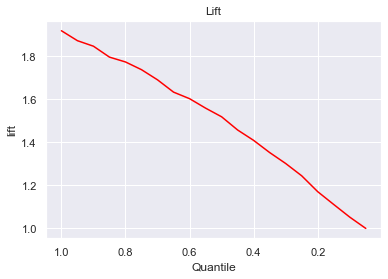

In [127]:
#Taking a look at the Boosted Tree lift curve
pyplot.plot(lifts["boostedTree"]["Quantile"], lifts["boostedTree"]["Lift"],color='red')
pyplot.gca().invert_xaxis()
pyplot.xlabel("Quantile")
pyplot.ylabel("lift")
pyplot.title("Lift")

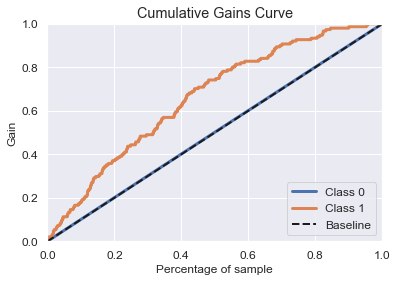

In [141]:
#Taking a look at the Boosted Tree cumulative gain curve
import scikitplot as skplt
import matplotlib.pyplot as plt


boostedTree.fit(trainingSet[featselected],trainingSet[target])
predicted_probas = boostedTree.predict_proba(testSet[featselected])



skplt.metrics.plot_cumulative_gain(testSet[target], predicted_probas)

plt.show()

Text(0.5, 1.0, 'Cumulative response')

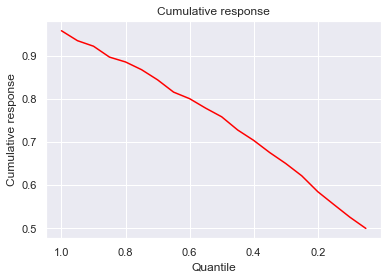

In [136]:
#Taking a look at the Boosted Tree cumulative response curve
pyplot.plot(responses["boostedTree"]["Quantile"], responses["boostedTree"]["Cumulative response"],color='red')
pyplot.gca().invert_xaxis()
pyplot.xlabel("Quantile")
pyplot.ylabel("Cumulative response")
pyplot.title("Cumulative response")